In [70]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import seaborn as sns
#sns.set(style="whitegrid")
import matplotlib.pyplot as plt
import itertools
from pathlib import Path
from tqdm import tqdm_notebook
pd.options.display.max_columns = None
%cd _bio_eval

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[Errno 2] No such file or directory: '_bio_eval'
/media/data/DeepFLaSH/_bio_eval


## Choose Labs

In [71]:
LAB = 'wue'#, 'wue_02', 'mue']
CODER = ['ens_rohini','ens_manju','ens_dennis','ens_cora','ens_corinna']
ENS = ['ens_6', 'ens_7', 'ens_8', 'ens_9']

results_path = os.path.join('_results','{}_effect.csv'.format(LAB))
f1_path = '{}/{}_f1_res.csv'.format(LAB, LAB)
f1_test_path = '{}/{}_test_all.csv.gz'.format(LAB, LAB)

#Load and convert effect results
df = pd.read_csv(results_path)
df['init'] = df['ens'].str[4:5]
df['name'] = df['unet'].str.extract(r'^(.+?)\_')
df['fold'] = df['fold'].str[-1:]
df['max_epochs'] = df['unet'].str.extract(r'.(\d+)\w{0,2}\_[sb]')
df['model_type'] = 'single'
df.loc[df['name']=='ens', 'model_type'] = 'ens' 
df.loc[(df.ens.isin(CODER))&(df.unet.str.startswith('ens')), 'model_type'] = 'ens_coder'
df.loc[(df.ens.isin(CODER))&(~df.unet.str.startswith('ens')), 'model_type'] = 'single_coder'

#Get F1 data 
if os.path.isfile(f1_path):
    df_f1 = pd.read_csv(f1_path)
    df_f1['unet'] = df_f1['CoderB']
    df_f1['fold'] = df_f1['Fold'].astype('int').astype('str')
    df_f1.loc[df_f1['unet'].str.startswith('px0_sc_cyc_'), 'unet'] = 'fr0_sc_cyc_all_cFOS_staple.0012.h5'
    df_f1 = df_f1.groupby(['unet','fold'])['f1_score','precision', 'recall'].mean().reset_index()
    df = pd.merge(df, df_f1, how='left', on=['unet','fold'])
else:
    df['f1_score'], df['precision'], df['recall'] = np.nan, np.nan, np.nan

#Get F1 test data 
if os.path.isfile(f1_test_path):
    df_f1_test = pd.read_csv(f1_test_path)
    df_f1_test['unet'] = df_f1_test['CoderB'].apply(lambda x: Path(x).name)
    df_f1_test = df_f1_test.groupby(['unet'])['f1_score','precision', 'recall'].mean().reset_index()
    df = pd.merge(df, df_f1_test, how='left', on=['unet'], suffixes=('', '_test'))
else:
    df['f1_score_test'], df['precision_test'], df['recall_test'] = np.nan, np.nan, np.nan

### Load WUE ALL

df_all = pd.read_csv('_results/wue_all_effect.csv')
df_all['init'] = df_all['ens'].str[4:5]
df_all['name'] = df_all['unet'].str.extract(r'^(.+?)\_')
df_all['fold'] = df_all['fold'].str[-1:]
df_all['max_epochs'] = df_all['unet'].str.extract(r'.(\d+)\w{0,2}\_[sb]')
df_all['model_type'] = 'single_all'
df_all.loc[df['name']=='ens', 'model_type'] = 'ens_all' 
df_all['f1_score'], df_all['precision'], df_all['recall'] = np.nan, np.nan, np.nan
df_f1_test = pd.read_csv('wue_all/wue_all_test_all.csv.gz')
df_f1_test['unet'] = df_f1_test['CoderB'].apply(lambda x: Path(x).name)
df_f1_test = df_f1_test.groupby(['unet'])['f1_score','precision', 'recall'].mean().reset_index()
df_all = pd.merge(df_all, df_f1_test, how='left', on=['unet'], suffixes=('', '_test'))
df = pd.concat([df, df_all],  sort=False)

### Create Effect Ensemble

df = df[~df.ens.isin(CODER)]
df_ens = (df.loc[~(df.unet.str[:3]=='ens')]
          .groupby(['ens', 'model_type','subarea','type'])['eta^2_kwa_all','eta^2_mwu1_vs_2','eta^2_mwu1_vs_3', 'eta^2_mwu2_vs_3','f1_score', 'f1_score_test']
          .agg(['mean']))
df_ens.columns = df_ens.columns.droplevel(1)
df_ens2 = (df.loc[~(df.unet.str[:3]=='ens')]
          .groupby(['ens', 'model_type','subarea','type'])['kwa_all', 'mwu1_vs_2', 'mwu1_vs_3', 'mwu2_vs_3']
          .agg(lambda x:x.value_counts().idxmax()))
df_ens = df_ens.join(df_ens2)
df_ens.reset_index(inplace=True)
df_ens['model_type'] = 'ens_effect'
df_ens['unet'] = df_ens['ens']
df_ens['anova_ok'] = False
df = pd.concat([df, df_ens], sort=False)

### Preproc

In [72]:
# Filter coders
df_coder = df[df.ens.isin(CODER)].copy()
df = df[~df.ens.isin(CODER)]
#df = df[~df.unet.isin(CODER)]
df_count = df[df.type=='norm_cfos_per_area']
df_int = df[df.type=='norm_mean_intensity']
#sc_cyc6_cFOS_staple_2 and corinna missing
# df[~(df['unet'].str[:3]=='ens')&(df.f1_score.isna())]

grp_names = df.columns[df.columns.str.contains('eta^2', regex=False)].str[6:]
# W/O Anova
grp_names = df.columns[(df.columns.str.contains('eta^2', regex=False))&(~df.columns.str.contains('aov', regex=False))].str[6:]
grp_names2 = grp_names[1:] if len(grp_names)>1 else grp_names
grp_names2

#Long Format
long_list = []
for grp_name in grp_names2:
    df_tmp = df.set_index(['unet', 'model_type','subarea','type'])[['eta^2_'+grp_name]+[grp_name]+['c_'+grp_name]+['c0.01_'+grp_name]+['c0.001_'+grp_name]
                                                                   +['anova_ok','f1_score', 'f1_score_test', 'init', 'ens']]
    df_tmp.rename(columns={'eta^2_'+grp_name:'eta', grp_name:'vote',
                          'c_'+grp_name: 'c_value', 
                           'c0.001_'+grp_name: 'c0.001_value',
                           'c0.01_'+grp_name: 'c0.01_value'}, inplace=True)
    df_tmp['effect'] = grp_name
    long_list += [df_tmp]
df_long = pd.concat(long_list, sort=False).reset_index()

### Anova?

In [4]:
(df_long[df_long.unet.str[:3]=='ens'].groupby(['subarea', 'type', 'effect']).anova_ok.agg(['mean', 'sum', 'count']))

mean  sum  count
subarea  type                effect                         
CA1      norm_cfos_per_area  mwu1_vs_2  0.000000  0.0      9
                             mwu1_vs_3  0.000000  0.0      9
                             mwu2_vs_3  0.000000  0.0      9
         norm_mean_intensity mwu1_vs_2  1.000000  9.0      9
                             mwu1_vs_3  1.000000  9.0      9
                             mwu2_vs_3  1.000000  9.0      9
CA3      norm_cfos_per_area  mwu1_vs_2  0.000000  0.0      9
                             mwu1_vs_3  0.000000  0.0      9
                             mwu2_vs_3  0.000000  0.0      9
         norm_mean_intensity mwu1_vs_2  1.000000  9.0      9
                             mwu1_vs_3  1.000000  9.0      9
                             mwu2_vs_3  1.000000  9.0      9
DG       norm_cfos_per_area  mwu1_vs_2  0.111111  1.0      9
                             mwu1_vs_3  0.111111  1.0      9
                             mwu2_vs_3  0.111111  1.0      9
         norm_mean_intensity mwu1_vs_2  0.000000  0.0      9
                             mwu1_vs_3  0.000000  0.0      9
                             mwu2_vs_3  0.000000  0.0      9
DG_infra norm_cfos_per_area  mwu1_vs_2  0.000000  0.0      9
                             mwu1_vs_3  0.000000  0.0      9
                             mwu2_vs_3  0.000000  0.0      9
         norm_mean_intensity mwu1_vs_2  1.000000  9.0      9
                             mwu1_vs_3  1.000000  9.0      9
                             mwu2_vs_3  1.000000  9.0      9
DG_supra norm_cfos_per_area  mwu1_vs_2  1.000000  9.0      9
                             mwu1_vs_3  1.000000  9.0      9
                             mwu2_vs_3  1.000000  9.0      9
         norm_mean_intensity mwu1_vs_2  0.000000  0.0      9
                             mwu1_vs_3  0.000000  0.0      9
                             mwu2_vs_3  0.000000  0.0      9

# Wue

### Per Effect Analysis

df_effect = df[df.model_type=='single'].groupby(['subarea', 'type'])[grp_names2].agg(lambda x:x.value_counts().idxmax())
#df_effect = df.groupby(['subarea', 'type'])[grp_names2].agg(lambda x:x.value_counts().idxmax())
display(df_effect)
print((df_effect>0).sum().sum())

In [5]:
df_effect = df_long.groupby(['subarea', 'type', 'effect'])[['vote']].agg(lambda x:x.value_counts().idxmax())
display(df_effect)
print((df_effect>0).sum().sum())

vote
subarea  type                effect         
CA1      norm_cfos_per_area  mwu1_vs_2     2
                             mwu1_vs_3     3
                             mwu2_vs_3     0
         norm_mean_intensity mwu1_vs_2     2
                             mwu1_vs_3     3
                             mwu2_vs_3     0
CA3      norm_cfos_per_area  mwu1_vs_2     2
                             mwu1_vs_3     3
                             mwu2_vs_3     2
         norm_mean_intensity mwu1_vs_2     2
                             mwu1_vs_3     0
                             mwu2_vs_3     2
DG       norm_cfos_per_area  mwu1_vs_2     2
                             mwu1_vs_3     3
                             mwu2_vs_3     0
         norm_mean_intensity mwu1_vs_2     0
                             mwu1_vs_3     0
                             mwu2_vs_3     0
DG_infra norm_cfos_per_area  mwu1_vs_2     0
                             mwu1_vs_3     0
                             mwu2_vs_3     0
         norm_mean_intensity mwu1_vs_2     0
                             mwu1_vs_3     0
                             mwu2_vs_3     0
DG_supra norm_cfos_per_area  mwu1_vs_2     2
                             mwu1_vs_3     3
                             mwu2_vs_3     0
         norm_mean_intensity mwu1_vs_2     2
                             mwu1_vs_3     3
                             mwu2_vs_3     0

15


In [6]:
df_var = df_long.join(df_effect, how='left', rsuffix='_ref', on=['subarea', 'type', 'effect'])
df_var['vote_diff'] = df_var['vote']!=df_var['vote_ref']
df_var_agg = (df_var.groupby(['subarea','type','model_type', 'effect'])[['vote_diff', 'eta']]
          .agg({'vote_diff' : ['sum', 'mean'], 'eta' : ['std', 'var', 'mean']}))
df_var_agg.columns = ['FDR', 'vote_diff_count', 'eta_std', 'eta_var', 'eta_mean']
df_var_agg.reset_index(inplace=True)

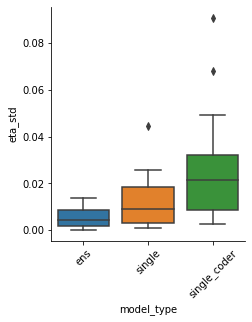

In [7]:
g = sns.catplot(x="model_type", y="eta_std",
                #hue="effect", 
                #col="subarea",
                #order=['single_coder', 'ens_coder', 'single', 'ens'],
                data=df_var_agg, kind="box",
                height=4, aspect=0.9).set_xticklabels(rotation=45);

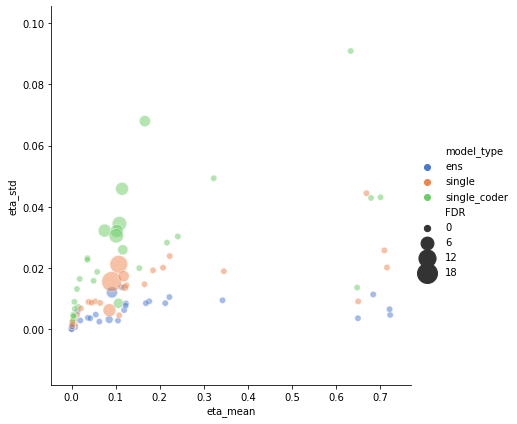

In [9]:
sns.relplot(x="eta_mean", y="eta_std", size="FDR",
            #x="mean", y="FDR",  size="std",
            #x="FDR", y="std",  size="mean",
            hue="model_type", 
            #hue_order= ['single_coder', 'ens_coder', 'single', 'ens'],
            sizes=(40, 400), 
            alpha=.5, palette="muted",
            height=6,aspect=1, data=df_var_agg);

In [10]:
df_varx = df_var[df_var.model_type.isin(['ens', 'single'])]
#df_varx['eta_bins'] = pd.cut(df_varx.eta, bins=25)
#df_varx_agg = df_varx.groupby(['eta_bins', 'model_type'])[['vote_diff', 'eta']].mean().reset_index()
df_varx_agg = df_varx.groupby(['subarea', 'type', 'model_type', 'effect'])[['vote_diff', 'eta']].mean().reset_index()
df_varx_agg['FDR'] = df_varx_agg['vote_diff']

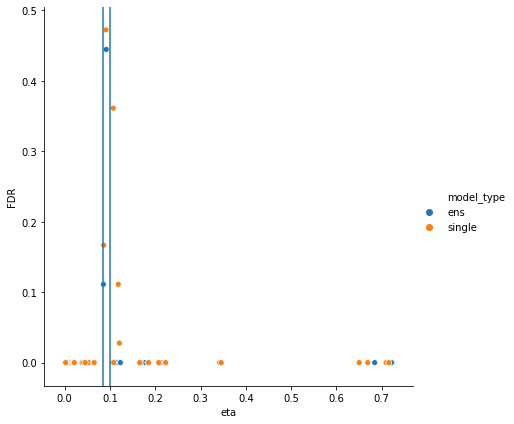

In [11]:
sns.relplot(x="eta", y="FDR", # size="mean",
            hue="model_type", 
            #hue_order=['single_coder', 'ens_coder', 'single', 'ens'],
            height=6,aspect=1, data=df_varx_agg);
plt.axvline(df_varx.c_value.min());
plt.axvline(df_varx.c_value.max());

### Per Model Analysis

In [12]:
df_stats = df_long.groupby(['subarea','effect', 'type','model_type']).eta.agg(['mean', 'min', 'max', 'std'])
df_model = df_long.set_index(['subarea','effect', 'type','model_type']).join(df_stats).reset_index()
df_model['eta_norm'] = np.sqrt((df_model['eta']-df_model['mean'])**2)
df_model = pd.merge(df_var[['subarea','type','model_type','unet', 'effect', 'vote_diff']], df_model, on=['subarea','type','model_type','unet', 'effect'])

df_model_agg = (df_model.groupby(['model_type','unet']).agg({'eta_norm' : ['std'], 'vote_diff' : ['mean', 'sum'], 'eta' : ['mean']}))
df_model_agg.columns = ['eta_norm_std', 'FDR', 'FDE', 'eta_mean']
df_model_agg['FDE'] = df_model_agg['FDE'].astype('int')
df_model_agg.reset_index(inplace=True)

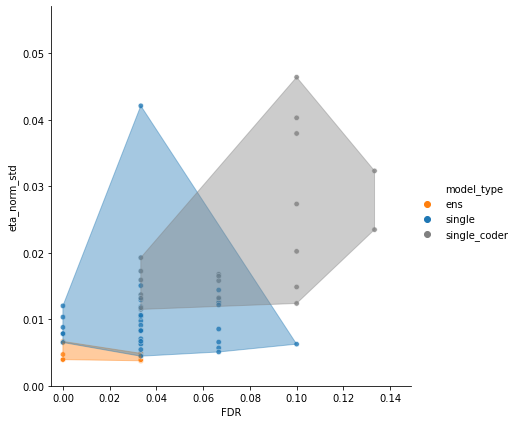

In [14]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
COLORS = ['C1', 'C0', 'grey']
g = sns.relplot(x="FDR", y="eta_norm_std", # size="mean",
            hue="model_type", 
            s =30, alpha=0.8,
            palette=['C1', 'C0', 'grey'],
            #hue_order=['single_coder', 'ens_coder', 'single', 'ens'],
            height=6,aspect=1, data=df_model_agg)#.set(ylim=(0.01, 0.02));
ax = g.axes[0][0]
for m_type, cmap in zip(df_model_agg.model_type.unique(), COLORS):
    df_tmp = df_model_agg.loc[df_model_agg.model_type == m_type]
    points = df_tmp[['FDR', 'eta_norm_std']].values
    hull = ConvexHull(points)
    ax.fill(points[hull.vertices,0], points[hull.vertices,1], color=cmap, alpha=0.4)
    #ax.autoscale(enable=True, axis='x', tight=True) 
    #ax.autoscale(enable=True, axis='y', tight=True) 
    ax.set_ylim(bottom=0)
    ax.set_xlim(-0.005)

#df_model_agg.to_csv('models_agg.csv', index=False)

df_model_agg.columns = df_model_agg.columns.droplevel(1)
df_model_agg.columns = ['eta_norm_std', 'FDR', 'FDE', 'eta_mean']
df_model_agg.rename(columns=[])
df_model_agg['FDR'] = df_model_agg[('vote_diff', 'mean')] 
df_model_agg['std_norm'] = df_model_agg[('eta_norm','std')]
df_model_agg['eta'] = df_model_agg[('eta','mean')]

g = sns.catplot(x="FDE", y="eta_norm_std", # size="mean",
            hue="model_type", #dodge=True,
            #s =5, alpha=0.8,
            palette=['C1', 'C0', 'grey'],
            kind='strip',
            #hue_order=['single_coder', 'ens_coder', 'single', 'ens'],
            height=6,aspect=1, data=df_model_agg)#.set(ylim=(0, 0.06));  

### F1 Analysis

In [18]:
#df_f1 = df_model[~df_model.f1_score.isna()].copy()
df_f1_agg = df_model.groupby(['model_type','unet']).agg({'eta_norm' : ['std'], 'vote_diff' : ['mean'], 'f1_score': ['mean'], 'f1_score_test': ['mean']})
df_f1_agg.columns = df_f1_agg.columns.droplevel(1)
df_f1_agg.reset_index(inplace=True)
df_f1_agg = pd.merge(df_f1_agg, df[['unet', 'fold']].drop_duplicates(), how='left', on='unet')
df_f1_agg['log_std'] = np.log(df_f1_agg['eta_norm'])
df_f1_agg['eta_std'] = df_f1_agg['eta_norm']
#df_f1_agg.head()

In [19]:
f1_ref = pd.read_csv('../iou_matches/coder_vs_train/coder_vs_coder.csv0.5.csv').drop_duplicates()
f1_ref = f1_ref[(f1_ref.CoderB=='staple')^(f1_ref.CoderA=='staple')]#.f1_score.mean()
#f1_ref.groupby(['CoderA', 'CoderB'])[['f1_score']].median()

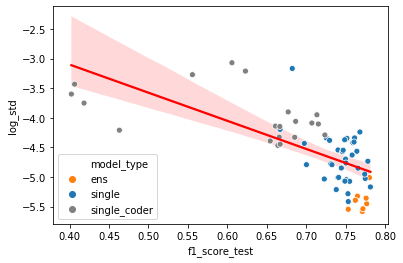

In [22]:
f1_value = "f1_score_test"#  "f1_score_test"
df_plot_rel = df_f1_agg#.loc[df_f1_agg.model_type.isin(['ens', 'single'])]
ax = sns.regplot(x=f1_value, y="log_std", scatter=False, color='red', data=df_f1_agg);
ax = sns.scatterplot(x=f1_value, y="log_std",palette=['C1', 'C0', 'grey'], # size="mean",
            hue="model_type", data=df_f1_agg);
plt.show()

In [23]:
import statsmodels.api as sm
# Fit and summarize OLS model
mod = sm.OLS(df_f1_agg.log_std, df_f1_agg.f1_score, missing='drop')
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                log_std   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                              3455.
Date:                Wed, 22 Apr 2020   Prob (F-statistic):                    1.03e-42
Time:                        20:15:29   Log-Likelihood:                         -31.629
No. Observations:                  44   AIC:                                      65.26
Df Residuals:                      43   BIC:                                      67.04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

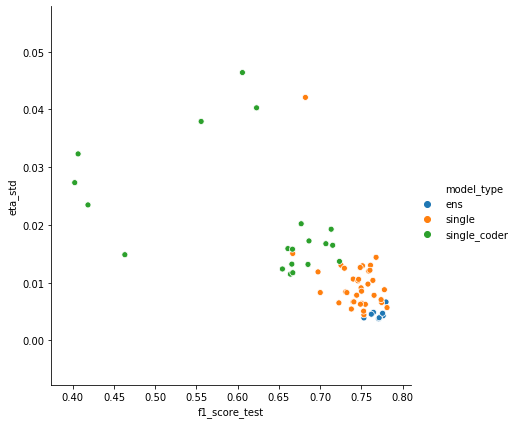

In [24]:
sns.relplot(x=f1_value, y="eta_std", # size="mean",
            hue="model_type",# hue_order=['single_coder', 'ens_coder', 'single', 'ens'],
            #alpha=.8, 
            height=6,aspect=1, data=df_f1_agg)#.set(ylim=(0, 0.02));

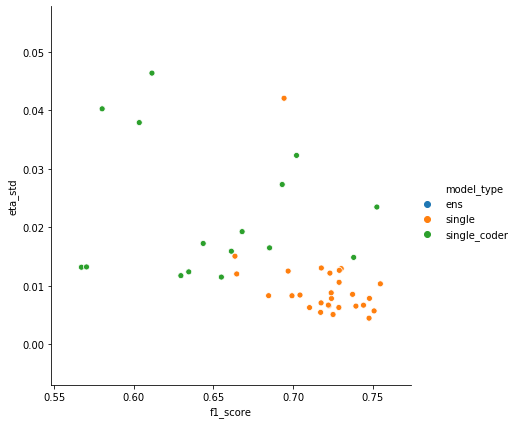

In [25]:
sns.relplot(x="f1_score", y="eta_std", # size="mean",
            hue="model_type",# hue_order=['single_coder', 'ens_coder', 'single', 'ens'],
            #alpha=.8, 
            height=6,aspect=1, data=df_f1_agg);

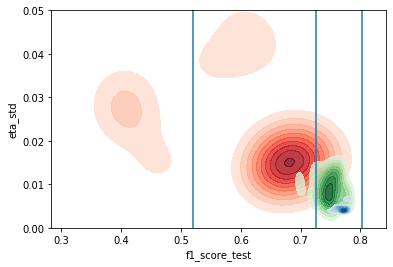

In [26]:
cmaps = ['Reds', 'Greens', 'Oranges', 'Blues']
m_types = ['single_all', 'single', 'ens_all', 'ens']
m_types = ['single_coder', 'single', 'ens_coder', 'ens']
f1_coder_mean = f1_ref.groupby(['CoderA', 'CoderB'])[['f1_score']].mean().mean()[0]
f1_coder_min = f1_ref.groupby(['CoderA', 'CoderB'])[['f1_score']].mean().min()[0]
f1_coder_max = f1_ref.groupby(['CoderA', 'CoderB'])[['f1_score']].mean().max()[0]
for m_type, cmap in zip(m_types, cmaps):
    df_kde = df_f1_agg.loc[df_f1_agg.model_type == m_type]
    ax = sns.kdeplot(df_kde.f1_score_test, df_kde.eta_std, 
                     cmap=cmap, shade=True, shade_lowest=False, 
                     alpha=0.8).set(ylim=(0, 0.05));
plt.axvline(f1_coder_mean)
plt.axvline(f1_coder_min)
plt.axvline(f1_coder_max);

# Detailed Plots

## Wue

('mwu1_vs_2', 'norm_cfos_per_area')


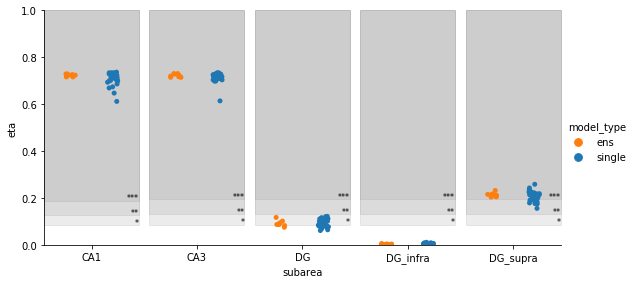

('mwu1_vs_2', 'norm_mean_intensity')


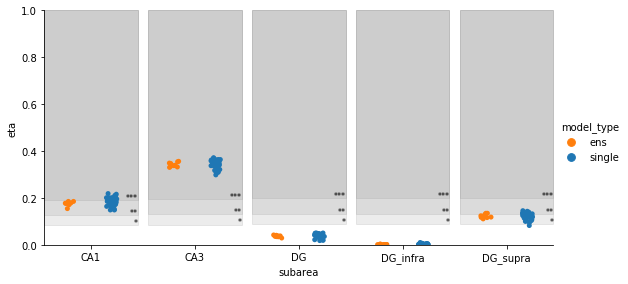

('mwu1_vs_3', 'norm_cfos_per_area')


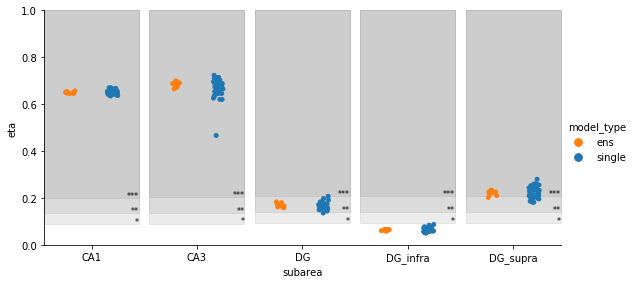

('mwu1_vs_3', 'norm_mean_intensity')


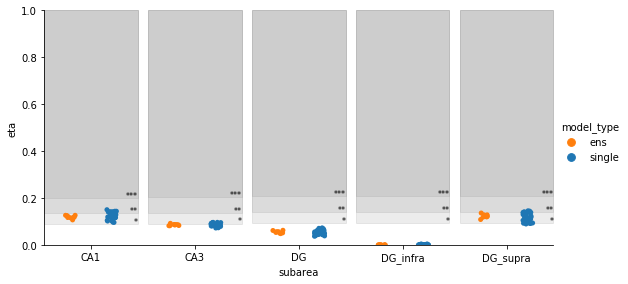

('mwu2_vs_3', 'norm_cfos_per_area')


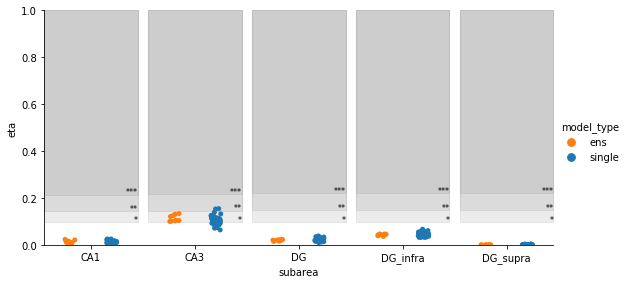

('mwu2_vs_3', 'norm_mean_intensity')


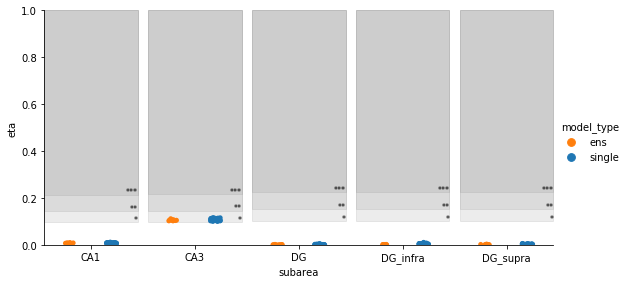

In [73]:
for key, grp in df_long.groupby(['effect', 'type']):
    print(key)
    g = sns.catplot(x='subarea', y='eta',# sizes=(50,60), s=grp.f1_score_test,
                hue='model_type',#,col="subarea",#col='init'
                palette=["C1","C0"],
                data=grp, kind="strip",dodge=True,legend_out=True,
                height=4, aspect=2, sharey=False).set_xticklabels(rotation=0).set(ylim=(0, 1))
    
    ax = g.axes[0][0]
    i=0.
    for subar in df.subarea.unique():
        star = '*'
        for c_val in ['c_value', 'c0.01_value','c0.001_value']:
            c_value = grp.loc[grp.subarea==subar, c_val]
            ax.fill_between([i-0.45,i+.45],c_value.mean(),1, alpha=0.15, color='grey', interpolate=True)
            ax.text(i+.45,c_value.mean(),star,rotation=0, fontsize=8, ha='right')
            star += '*'
        i += 1.
        #ax.axhline(y=c_value.mean(), ls='--', c='black', lw=0.5)
        #ax.fill_between([i-0.4,i+.4],0,c_value.mean(), alpha=0.2, color='grey', interpolate=True)

    ax.autoscale(enable=True, axis='x', tight=True)    
    plt.show()

('mwu1_vs_2', 'norm_cfos_per_area')


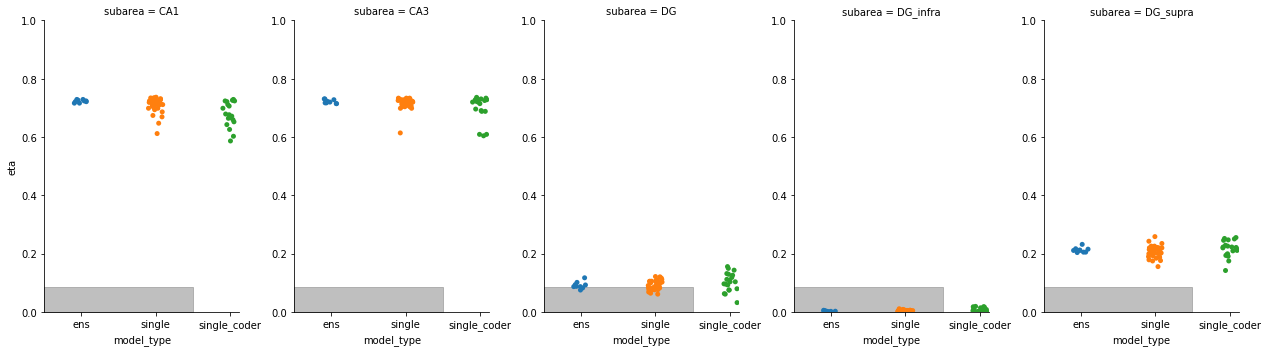

('mwu1_vs_2', 'norm_mean_intensity')


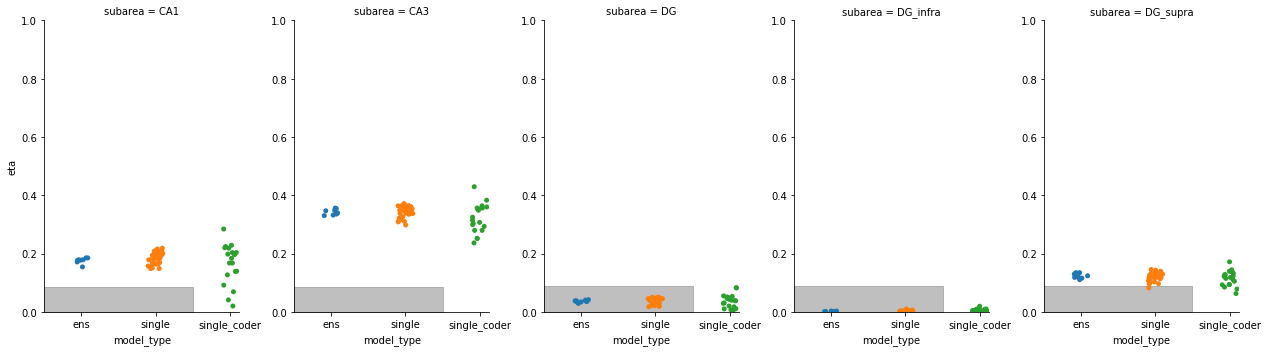

('mwu1_vs_3', 'norm_cfos_per_area')


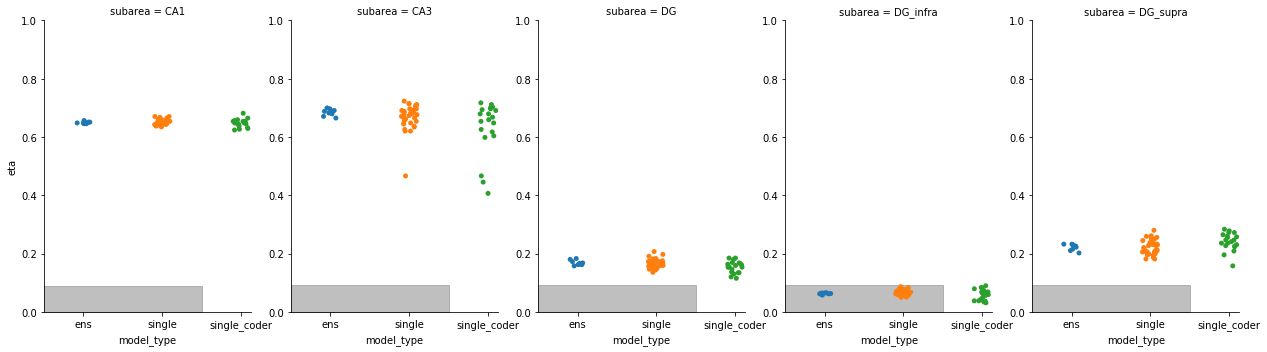

('mwu1_vs_3', 'norm_mean_intensity')


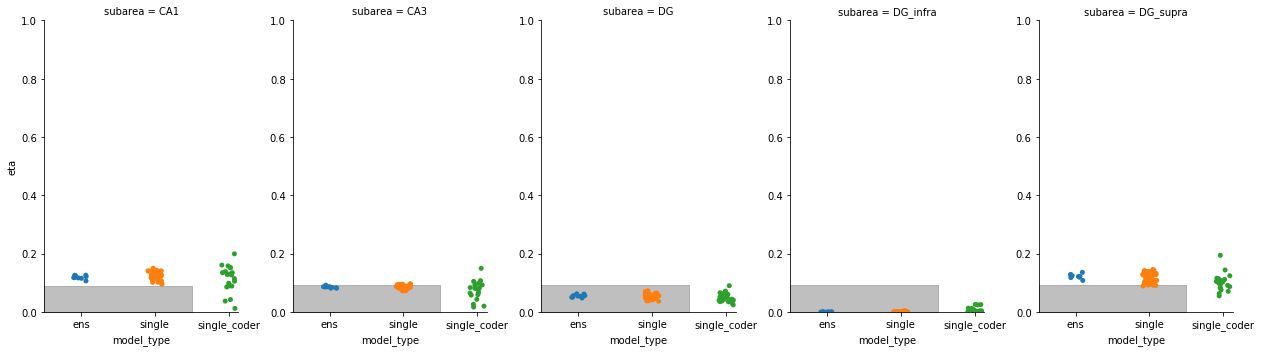

('mwu2_vs_3', 'norm_cfos_per_area')


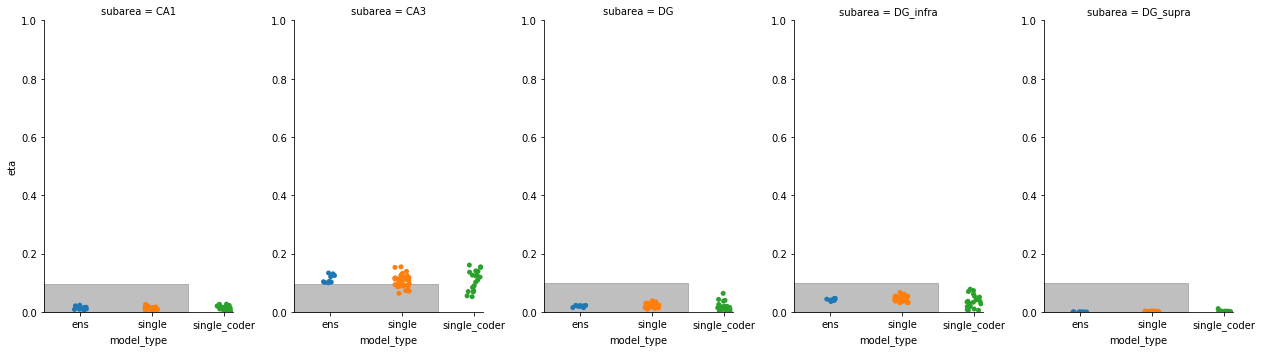

('mwu2_vs_3', 'norm_mean_intensity')


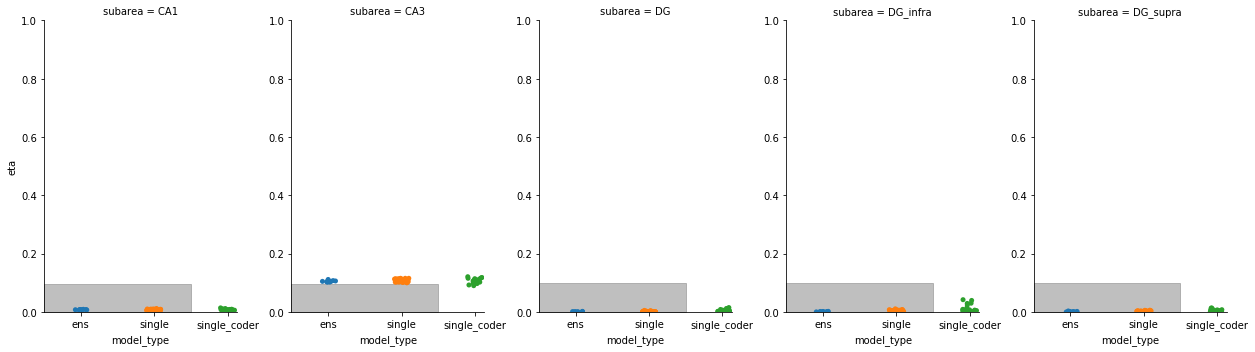

In [29]:
for key, grp in df_long.groupby(['effect', 'type']):
    print(key)
    g = sns.catplot(x='model_type', y='eta',# sizes=(50,60), s=grp.f1_score_test,
                hue='model_type',col="subarea",#col='init'
                #order=['ens', 'ens_all', 'single', 'single_all'],
                data=grp, kind="strip",dodge=False,legend_out=True,
                height=5, aspect=0.7, sharey=False).set_xticklabels(rotation=0).set(ylim=(0, 1))

    for ax, subar in zip(*g.axes, df.subarea.unique()):
        c_value = grp.loc[grp.subarea==subar, 'c_value']
        #ax.axhline(y=c_value.mean(), ls='--', c='black', lw=0.5)
        ax.fill_between([-0.5,1+.5],0,c_value.mean(), alpha=0.5, color='grey', interpolate=True)
        ax.autoscale(enable=True, axis='x', tight=True)
        #ax.text(x=2, y=c_value.mean()+0.001, s='critical value', ha='right', va='center')
    
    plt.show()

## Labs

inns_01 norm_cfos_per_area


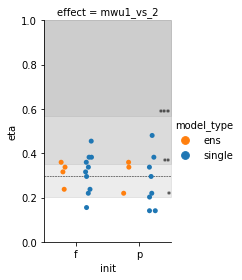

inns_01 norm_mean_intensity


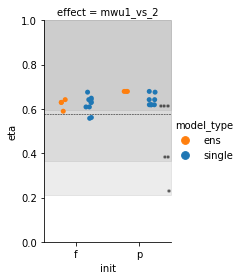

In [68]:
df_plot = df_long[df_long.init.isin(['f','p'])]
x_ref = df_long[df_long.unet.str.startswith('fr0')].reset_index()
for key, grp in df_plot.groupby(['type']):
    print(LAB, key)
    #for eff in grp.effect.unique():
    #    for init in grp.init.unique():
    #        x_ref2 = x_ref.loc[(x_ref.type==key)&(x_ref.effect==eff)]
    #        x_ref2.loc[:, 'model_type'] = 'baseline'
    #        x_ref2.loc[:, 'init'] = init
    #        grp = pd.concat([grp, x_ref2[0:1]], sort=False, ignore_index= True)
    g = sns.catplot(x='init', y='eta',# sizes=(50,60), s=grp.f1_score_test,
                hue='model_type',col="effect",#col='init'
                palette=["C1","C0", 'black'],
                data=grp, kind="strip",dodge=True,legend_out=True,
                height=4, aspect=0.7, sharey=False, sharex=False).set_xticklabels(rotation=0).set(ylim=(0, 1))
    
    for ax, eff in zip(*g.axes, grp.effect.unique()):
        x_eta = x_ref.loc[(x_ref.type==key)&(x_ref.effect==eff), 'eta'].values.mean()
        ax.axhline(y=x_eta, ls='--', c='black', lw=0.5)
        #ax.text(0.9,x_eta-0.04,'Baseline',rotation=0,  fontsize=8)
        star = '*'
        for c_val in ['c_value', 'c0.01_value','c0.001_value']:
            c_value = grp.loc[grp.effect==eff, c_val]
            ax.fill_between([0-0.5,1+.5],c_value.mean(),1, alpha=0.15, color='grey', interpolate=True)
            ax.text(1.5,c_value.mean(),star,rotation=0,  fontsize=8, ha='right')
            star += '*'
        ax.autoscale(enable=True, axis='x', tight=True) 
    
    plt.show()

In [60]:
star = '*'

In [63]:
star

'**'

Count
kwa_all


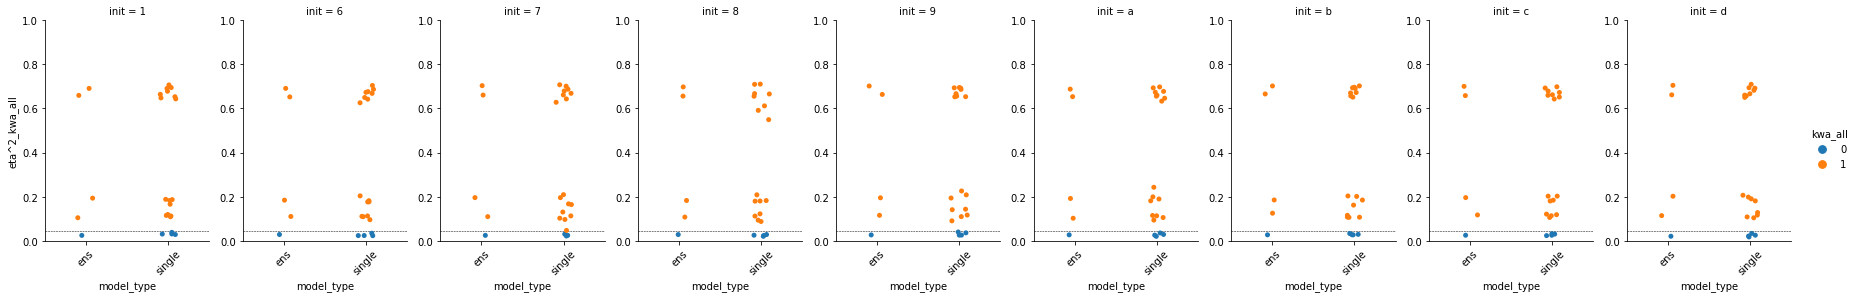

mwu1_vs_2


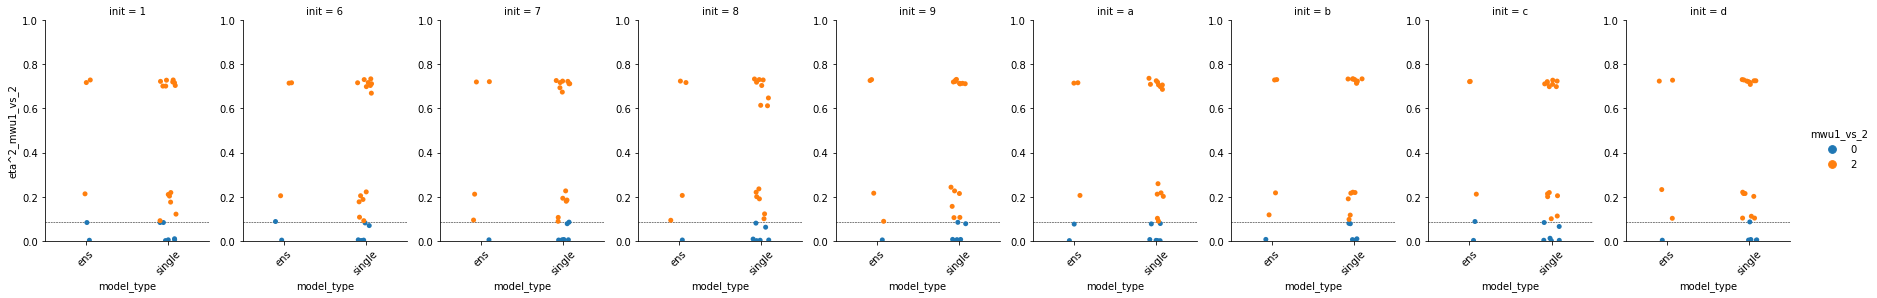

mwu1_vs_3


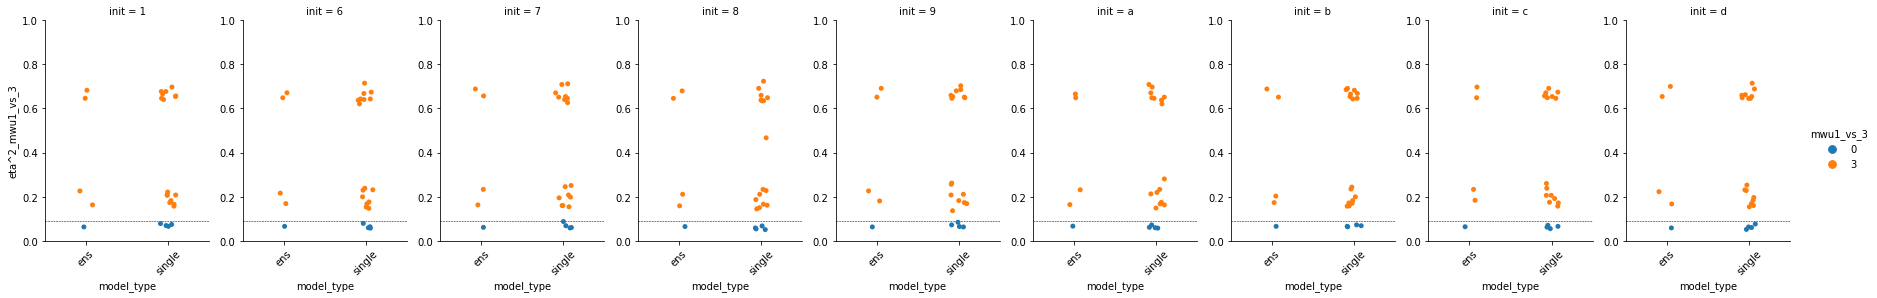

mwu2_vs_3


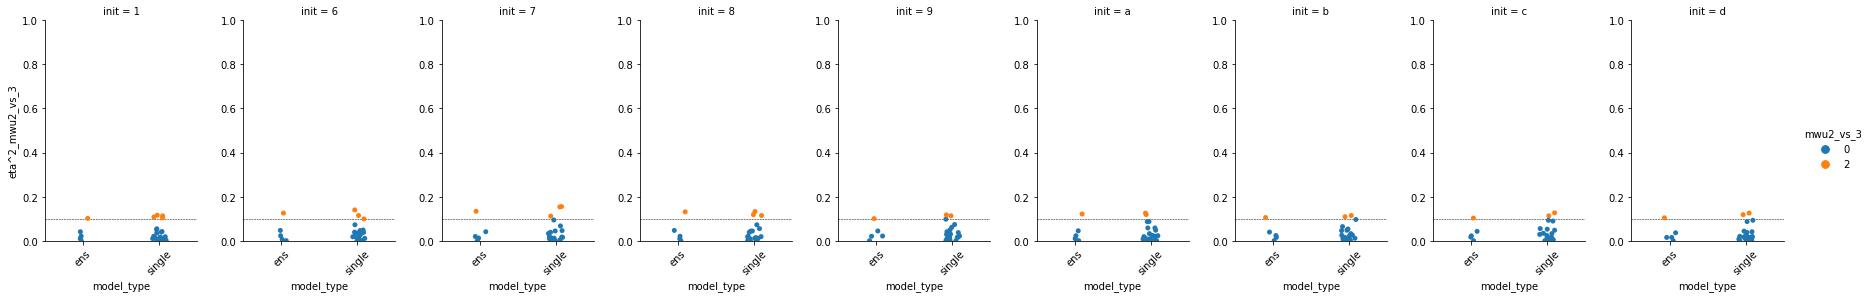

In [41]:
inits = df.init.unique()
df_plot = df_count
print('Count')
for grp_name in grp_names:
    print(grp_name)
    g = sns.catplot(x='model_type', y='eta^2_{}'.format(grp_name), 
                hue=grp_name, col="init",#col='init'
                #order=['ens', 'ens_all', 'single', 'single_all'],
                data=df_plot, kind="strip",dodge=False,legend_out=True,
                height=4, aspect=0.7, sharey=False).set_xticklabels(rotation=45).set(ylim=(0, 1))
    
    for ax, subar in zip(*g.axes, inits):
        c_value = df_plot.loc[df_plot.init==subar, 'c_{}'.format(grp_name)]
        ax.axhline(y=c_value.mean(), ls='--', c='black', lw=0.5)
        #ax.text(x=2, y=c_value.mean()+0.001, s='critical value', ha='right', va='center')
    plt.show()

## Labs

f1_score_means = df_long[df_long.model_type=='single'].groupby('ens')['f1_score'].mean()
df_long.loc[df_long.model_type=='ens', 'f1_score'] = df_long.loc[df_long.model_type=='ens'].drop(['f1_score'], axis=1).join(f1_score_means, on='ens')['f1_score']

In [ ]:
for key, grp in df_long.groupby(['type', 'effect']):
    print(key)
    g = sns.catplot(x='model_type', y='eta', # sizes=(20,80), s=grp.f1_score,
                hue='vote', col="init",#col='init'
                #order=['ens', 'ens_all', 'single', 'single_all'],
                data=grp, kind="strip",dodge=False,legend_out=True,
                height=4, aspect=0.7, sharey=False).set_xticklabels(rotation=45)#.set(ylim=(0, 1))

    for ax, subar in zip(*g.axes, grp.init.unique()):
        c_value = grp.loc[grp.init==subar, 'c_value']
        ax.axhline(y=c_value.mean(), ls='--', c='black', lw=0.5)
        #ax.text(x=2, y=c_value.mean()+0.001, s='critical value', ha='right', va='center')
    plt.show()

### Coder

In [ ]:
df_coder['model_type2'] = df_coder['ens'].str[4:]+'_'+df_coder['model_type']
df_coder_count = df_coder[df_coder.type=='norm_cfos_per_area']
df_coder_int = df_coder[df_coder.type=='norm_mean_intensity']

In [ ]:
for grp_name in grp_names:
    print(grp_name)
    g = sns.catplot(x='model_type', y='eta^2_{}'.format(grp_name), 
                hue='model_type2', col="subarea",#col='init'
                #order=['ens', 'ens_all', 'single', 'single_all'],
                data=df_coder_count, kind="box",dodge=True,legend_out=True,
                height=6, aspect=0.7, sharey=False, sharex=False).set_xticklabels(rotation=45).set(ylim=(0, 1))
    c_value = df_coder_count['c_{}'.format(grp_name)]
    g = g.map(plt.axhline, y=c_value.mean(), ls='--', c='black', lw=0.5)#xmin=0.2, xmax=0.8,
    plt.show()

In [ ]:
for grp_name in grp_names:
    print(grp_name)
    g = sns.catplot(x='model_type', y='eta^2_{}'.format(grp_name), 
                hue='model_type2', col="subarea",#col='init'
                #order=['ens', 'ens_all', 'single', 'single_all'],
                data=df_coder_count, kind="box",dodge=True,legend_out=True,
                height=6, aspect=0.7, sharey=False, sharex=False).set_xticklabels(rotation=45).set(ylim=(0, 1))
    c_value = df_coder_count['c_{}'.format(grp_name)]
    g = g.map(plt.axhline, y=c_value.mean(), ls='--', c='black', lw=0.5)#xmin=0.2, xmax=0.8,
    plt.show()

In [ ]:
for grp_name in grp_names:
    print(grp_name)
    g = sns.catplot(x='model_type', y='eta^2_{}'.format(grp_name), 
                hue='model_type2', col="subarea",#col='init'
                #order=['ens', 'ens_all', 'single', 'single_all'],
                data=df_coder_int, kind="box",dodge=True,legend_out=True,
                height=6, aspect=0.7, sharey=False, sharex=False).set_xticklabels(rotation=45).set(ylim=(0, 1))
    c_value = df_coder_int['c_{}'.format(grp_name)]
    g = g.map(plt.axhline, y=c_value.mean(), ls='--', c='black', lw=0.5)#xmin=0.2, xmax=0.8,
    plt.show()

In [ ]:
grp_names = df.columns[df.columns.str.contains('eta^2', regex=False)].str[6:]
for key, grp in df_count.groupby(['subarea']):
    for grp_name in grp_names:
        print(grp_name)
        g = sns.catplot(x='model_type', y='eta^2_{}'.format(grp_name), 
                    hue=grp_name, col="init",
                    data=grp, kind="strip",dodge=False,
                    height=4, aspect=0.75).set(ylim=(0, 1))
        c_value = df['c_{}'.format(grp_name)].unique()
        g = g.map(plt.axhline, y=c_value.mean(), xmin=0.2, xmax=0.8, ls='--', c='black', lw=0.5)
        path_fig = os.path.join('_figures',LAB,'effect_strip')
        if not os.path.isdir(path_fig): os.makedirs(path_fig)
        plt.savefig(os.path.join(path_fig,key+'_'+grp_name+'.png'))
        plt.show()
        plt.close()